In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [35]:
plt.style.use('ggplot')
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!


True

In [36]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')

In [37]:
df.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [38]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [39]:
df.shape

(568454, 10)

In [40]:
df = df.head(5000)
df.shape

(5000, 10)

# Quick Eda

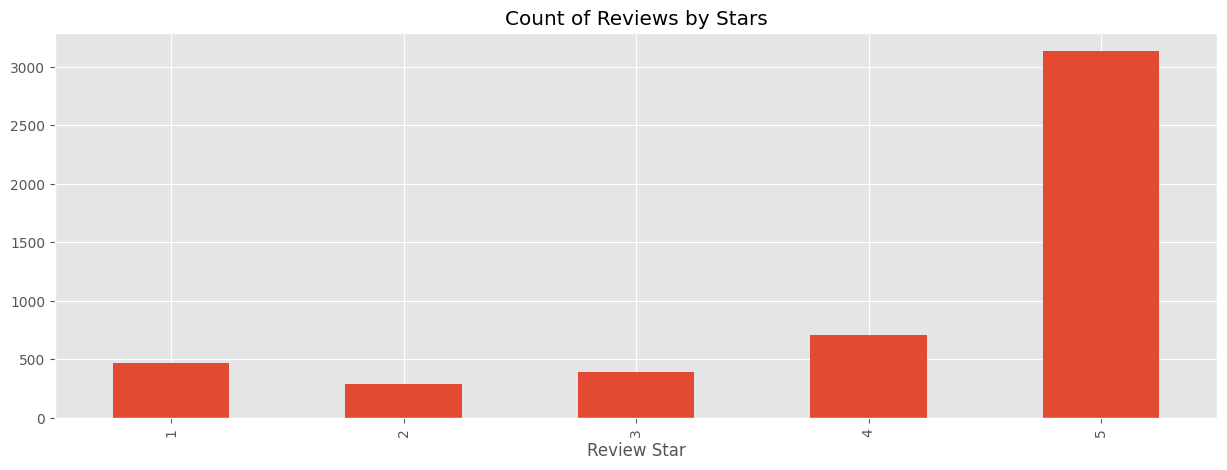

In [41]:
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Reviews by Stars', figsize = (15,5))

ax.set_xlabel('Review Star')
plt.show()

## Basic Nltk

In [42]:
example = df['Text'][50]

In [43]:
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [44]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [45]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [46]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. Vader Sentiment Scoring

## we will use NTK's sentimentIntensityAnalyser to get the neg/neu/pos scores of the text.

* This uses a "bag of words" approach:
     1. Stop words are removed
     2. Each word is scored and combined to a total score

* Note: The method does not include the relatation between words, and for human speach pov it is very important

In [47]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.auto import tqdm

sia = SentimentIntensityAnalyzer()

In [48]:
sia.polarity_scores("I am so so happy")
# a normalized, weighted composite score that represents the overall sentiment

{'neg': 0.0, 'neu': 0.371, 'pos': 0.629, 'compound': 0.726}

In [49]:
sia.polarity_scores("This is the worst  thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [50]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [51]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [52]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})


In [53]:
vaders = vaders.merge(df, how='left')

## Ploting Vader Results!

In [54]:
import seaborn as sns

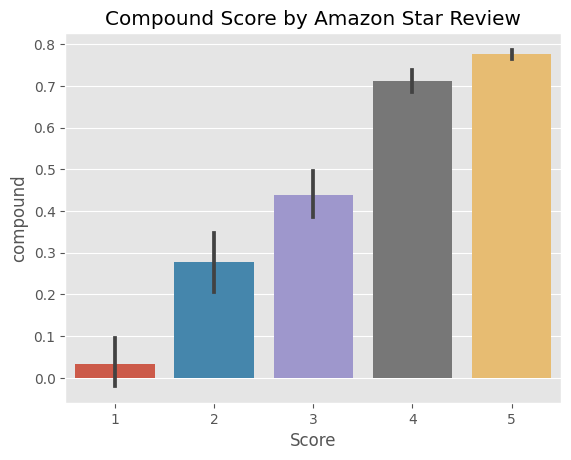

In [55]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

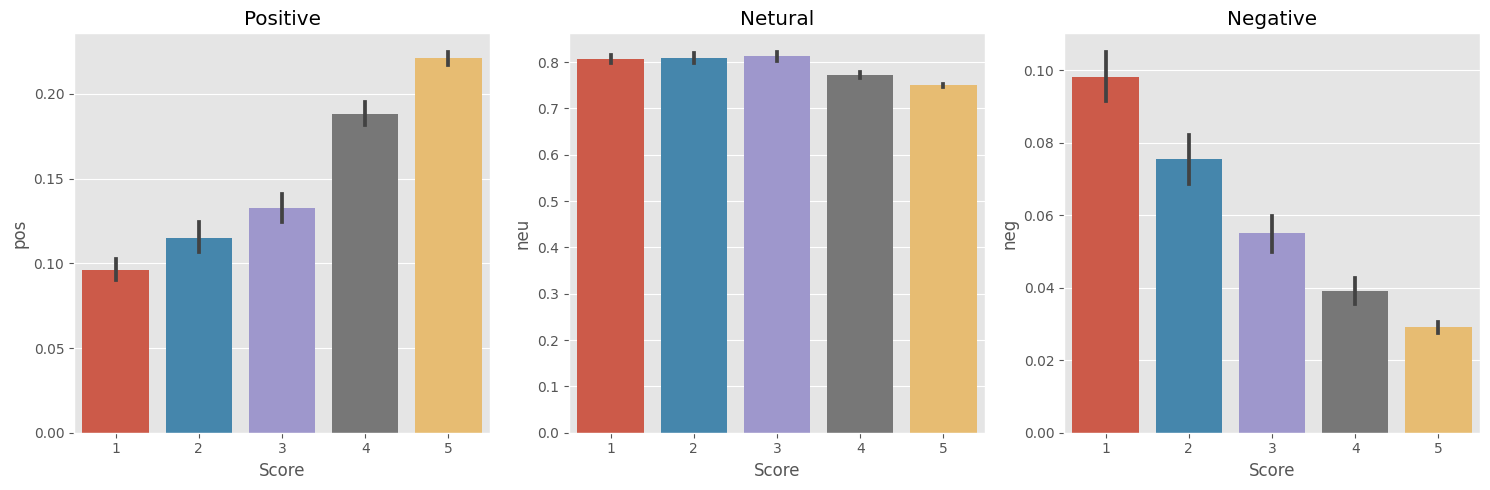

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x='Score', y='pos', ax= axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax = axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Netural')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

* Use a model trained of a large corpus of data.
* Transformers model accounts for the words but also the context related to the other words.

In [57]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [58]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [59]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [60]:
# Run for roberta Model

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687463,
 'roberta_pos': 0.002957368}

In [61]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [62]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f"Broke fro id {myid}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke fro id 83
Broke fro id 187
Broke fro id 529
Broke fro id 540
Broke fro id 746
Broke fro id 863
Broke fro id 1053
Broke fro id 1070
Broke fro id 1156
Broke fro id 1321
Broke fro id 1375
Broke fro id 1498
Broke fro id 1575
Broke fro id 1796
Broke fro id 1826
Broke fro id 2169
Broke fro id 2248
Broke fro id 2476
Broke fro id 2492
Broke fro id 2584
Broke fro id 2610
Broke fro id 2897
Broke fro id 2898
Broke fro id 2902
Broke fro id 2928
Broke fro id 2942
Broke fro id 2944
Broke fro id 2947
Broke fro id 2948
Broke fro id 3022
Broke fro id 3023
Broke fro id 3025
Broke fro id 3306
Broke fro id 3788
Broke fro id 3969
Broke fro id 4107
Broke fro id 4110
Broke fro id 4307
Broke fro id 4316
Broke fro id 4408
Broke fro id 4483
Broke fro id 4512
Broke fro id 4553
Broke fro id 4583


In [63]:
both

{'vader_neg': 0.0,
 'vader_neu': 0.717,
 'vader_pos': 0.283,
 'vader_compound': 0.9923,
 'roberta_neg': 0.009068501,
 'roberta_neu': 0.052034084,
 'roberta_pos': 0.93889743}

In [67]:
result_df = pd.DataFrame(res).T
# results_df = results_df.reset_index().rename(columns={'index': 'Id'})
# results_df = results_df.merge(df, how='left')

In [69]:
result_df = result_df.reset_index().rename(columns={'index': 'Id'})
result_df = result_df.merge(df, how='left')

# Compare Scores between models

In [72]:
result_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [76]:
result_df.replace([np.inf, -np.inf], np.nan, inplace=True)
result_df.dropna(inplace=True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

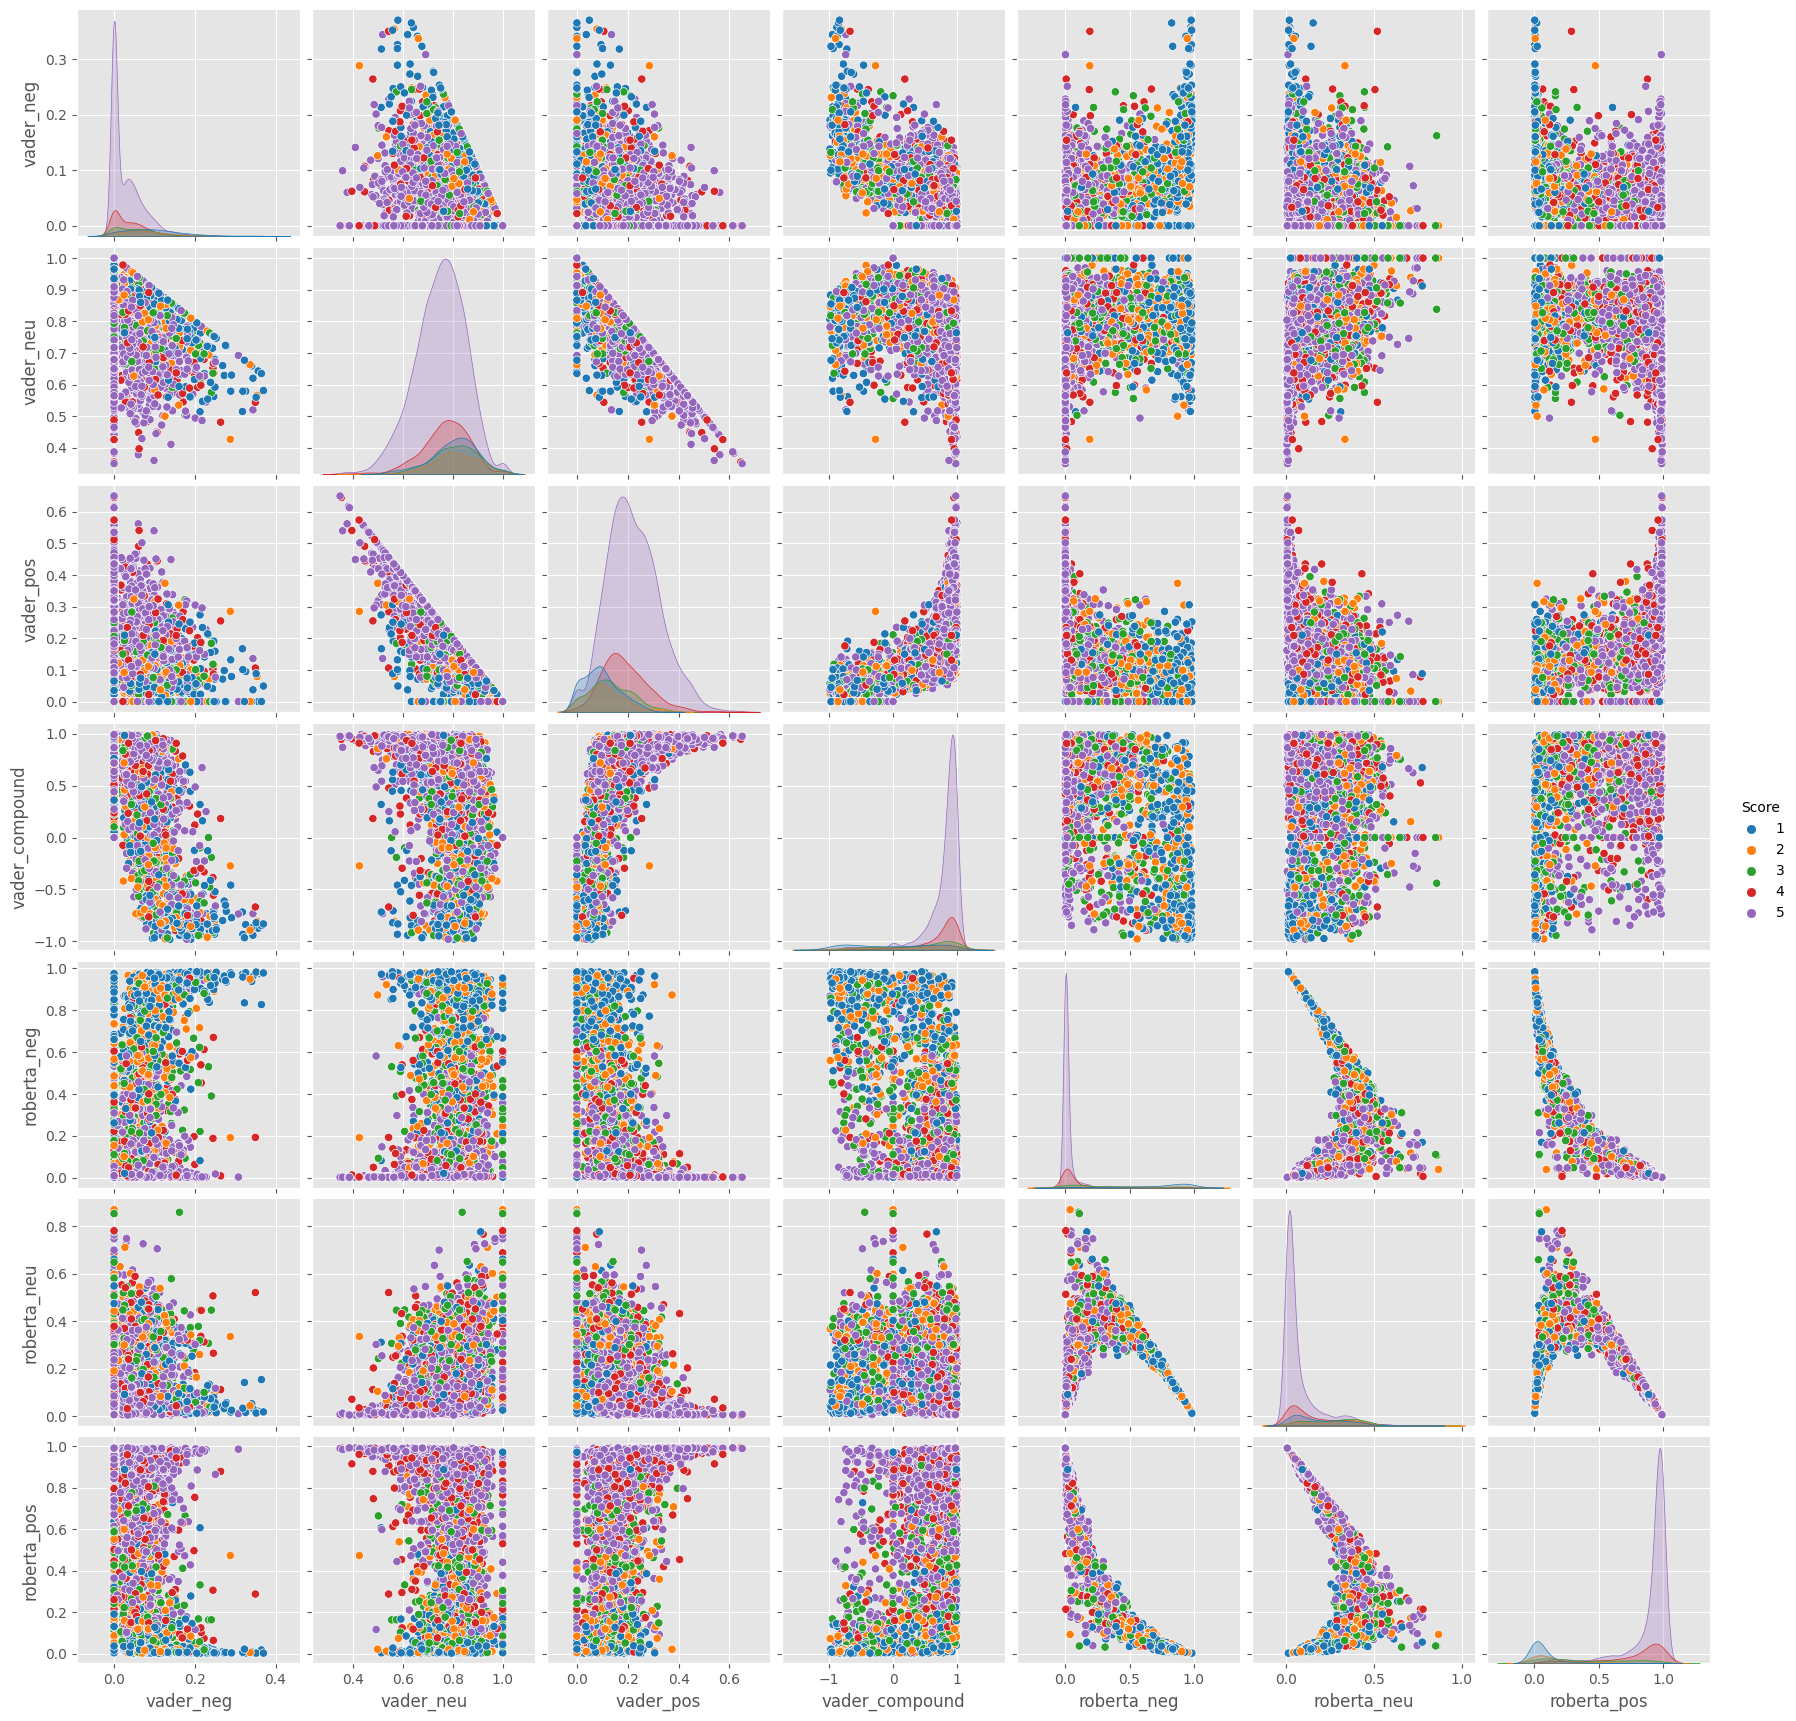

In [79]:
sns.pairplot(data=result_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                                   'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score', palette='tab10')
plt.show()


# Step 4: Review Example

* Positive 1-Star and Negative 5-Star Reviews

  Lets look at some examples where the model scoring and review score differ the most

In [81]:
result_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [82]:
result_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

"Second ingredient is SUGAR! Need I say more? Make your own bisquit mix, it's super easy!"

In [87]:
# Negative Sentence 5-Star Review

result_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline

* Quick & easy way to run sentiment prediction

In [4]:
from transformers import pipeline

2025-07-13 17:14:43.423689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752426883.601147      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752426883.654216      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
sent_pipeline = pipeline()

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [6]:
sent_pipeline('I love you')

[{'label': 'POSITIVE', 'score': 0.9998656511306763}]